### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline
from scipy.optimize import curve_fit
import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc, rcParams

import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance, mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
import pydot
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as BK
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf
#from sklearn.inspection import partial_dependence, plot_partial_dependence

global_rand_state_split = 0
global_rand_state_xgb = 0

2023-01-25 14:35:30.888581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 14:35:31.490692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/kianoosh/anaconda3/envs/tf/lib/
2023-01-25 14:35:31.490751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/

In [2]:
# proxy properties
# read the input data
df = pd.read_csv('FJH_ML_Final_simulation_90rem.csv', header=1)
df_dummy = pd.get_dummies(df)

df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']

Norm_I_Max = np.array (df['Norm_I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
df['Graphene_Yield'] = 100*df['Graphene_Yield']
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

# only process parameters that are in BO prediction
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)

In [3]:
# type of material
Material_CB = np.array (df_dummy['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df_dummy['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df_dummy['Material_PA']).reshape(-1, 1)
Material_TCB = np.array (df_dummy['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA, Material_TCB), axis=1)

material_matrix = np.concatenate((np.array (df_dummy['Material_CB']).reshape([-1, 1]), 
                                  np.array (df_dummy['Material_MC']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_PA']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_TCB']).reshape([-1, 1])), axis=1)
material_matrix = np.array (material_matrix)

In [4]:
# physical properties of precursor received from Kevin
CB_ps_res_sa_sp2 = [45, 2.8, 1750, 41.2]
MC_ps_res_sa_sp2 = [150, 0.4, 18, 45.9]
PA_ps_res_sa_sp2 = [125, 7.2, 62, 42.4]
TCB_ps_res_sa_sp2 = [106, 6.3, 74, 30.6]
CB_MC_PA_TCB_ps_res_sa_sp2 = np.concatenate ([CB_ps_res_sa_sp2,
                 MC_ps_res_sa_sp2,
                 PA_ps_res_sa_sp2,
                 TCB_ps_res_sa_sp2], axis=0).reshape(4,4)
X_CB_MC_PA_TCB_ps_res_sa_sp2 = np.matmul(material_matrix, CB_MC_PA_TCB_ps_res_sa_sp2)

In [5]:
# type of Atmosphere
Atmosphere_air = np.array (df_dummy['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df_dummy['Atmosphere_arg']).reshape(-1, 1)
#Atmosphere_vac = np.array (df_dummy['Atmosphere_vac']).reshape(-1, 1)
atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg), axis=1)

mean r2:  0.39343768318504124
mean pearson r:  0.681146697100142
coef_:  [ 0.03680388 -0.01278332  0.00051703 -0.02450201  0.00906398 -0.01039878
  0.0074884  -0.01376816 -0.01009234]
Gamma score: 0.07610282609154106
r-squared 0.15833020941341835
mse:  0.026829983642867934
pearson r PearsonRResult(statistic=0.5911209279412851, pvalue=0.00018466862061910697)


Text(0, 0.5, 'Pred. I_Final/I_Max')

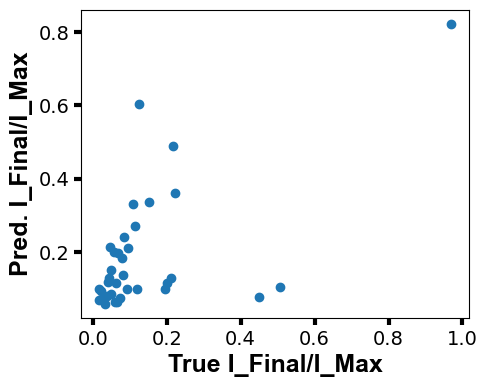

In [6]:
# Final_Current_Percent as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Final_Current_Percent
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                 Res_Drop, Volt_Drop, Graphene_Yield), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 50):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.4, random_state=i)
    clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=global_rand_state_split)

clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0:4]
y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True I_Final/I_Max', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. I_Final/I_Max', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Final_Current_Percent), np.max(Final_Current_Percent), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

mean r2:  0.5135462408568092
mean pearson r:  0.7684904007491176
coef_:  [ 1.17679741e-03  4.03526442e-03 -5.25192667e-03  3.14410138e-05
 -1.53511382e-02  8.37576017e-03  5.08746067e-03 -3.27066551e-02
  1.19830945e-02 -2.66882469e-02  3.12476224e-03]
Gamma score: 0.44955206595184705
r-squared 0.5361865724453492
mse:  225647.9942092304
pearson r PearsonRResult(statistic=0.8314512219436768, pvalue=6.183987745662709e-10)


Text(0, 0.5, 'Pred. Norm_I_Max')

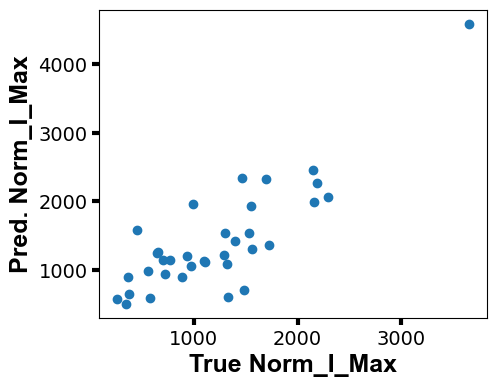

In [7]:
# Norm_I_Max as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Norm_I_Max
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                 Res_Drop, Volt_Drop), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=i)
    clf = linear_model.GammaRegressor(alpha=0.1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# get the average of all coef with different random states.
CB_MC_PA_coef_Norm_I_Max = np.mean (np.array(coef_mat_S), axis=0)
# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=global_rand_state_split)
clf = linear_model.GammaRegressor(alpha=0.1, max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]

y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True Norm_I_Max', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. Norm_I_Max', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Norm_I_Max), np.max(Norm_I_Max), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

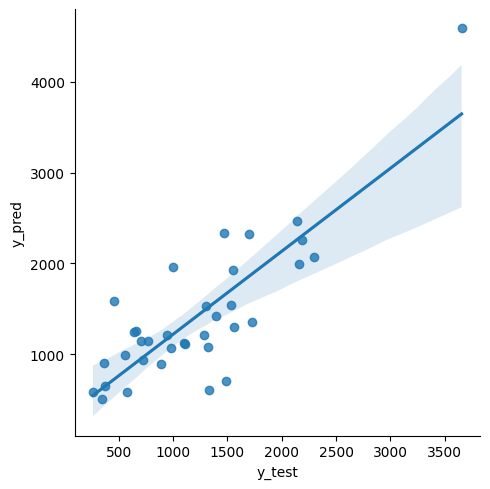

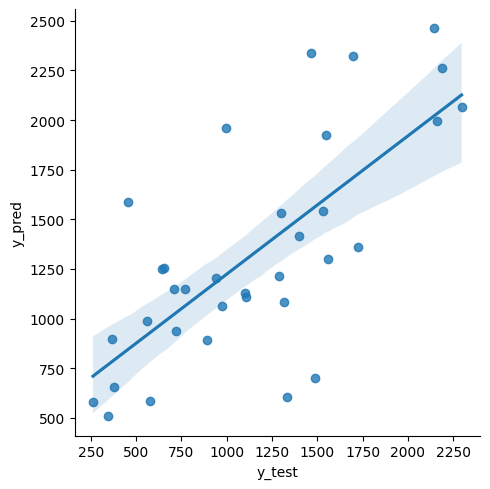

In [8]:
data = pd.DataFrame(())
data['y_test'] = y_test[:, 0]
data['y_pred'] = y_pred
sns.lmplot(data=data, x='y_test', y='y_pred')
# After removing outliers
sns.lmplot(data=data.loc[data['y_test']<3000], x='y_test', y='y_pred')

Gamma score: 0.4787353934019011
r-squared 0.5730880742718834
mse:  393.6997360922505
pearson r PearsonRResult(statistic=0.7718479692907193, pvalue=5.66934075804804e-08)


Text(0, 0.5, 'Pred. Norm_charge_tot')

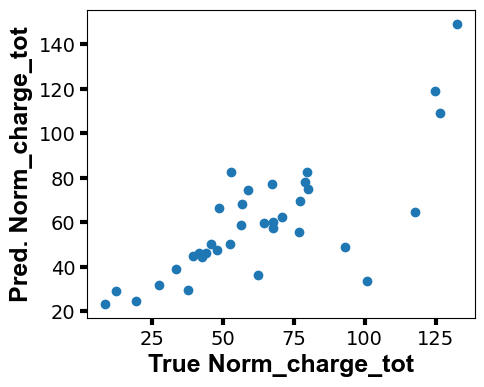

In [9]:
# Norm_charge_tot as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Norm_charge_tot
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 Res_Drop, Volt_Drop), axis=1)

# get the average of all coef with different random states.
#CB_MC_PA_coef_Norm_charge_tot = np.mean (np.array(coef_mat_S), axis=0)
# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=global_rand_state_split)
clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0:4]
#print ('coef_: ', clf.coef_)

y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True Norm_charge_tot', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. Norm_charge_tot', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Norm_charge_tot), np.max(Norm_charge_tot), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

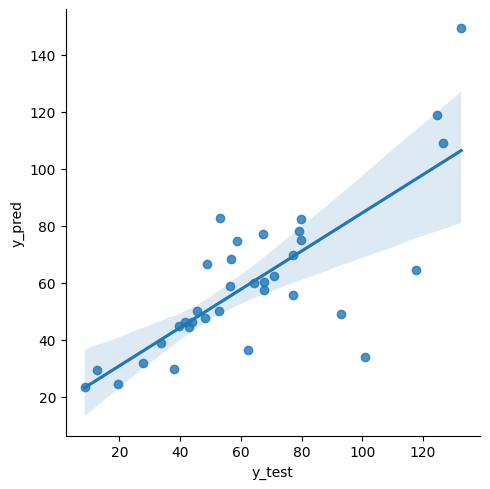

In [10]:
data = pd.DataFrame(())
data['y_test'] = y_test[:, 0]
data['y_pred'] = y_pred
sns.lmplot(data=data, x='y_test', y='y_pred')

In [11]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

# multiply 100 to the numbers, make them more strong !!!!!!!!!!1
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

In [12]:
# proxy (current-time plot) prediction (Final_Current_percent)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_I_Finalperc_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=global_rand_state_split
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, df['Material'],
                                       indices, test_size = 0.20, random_state = rand)

feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_CB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']
new_features[0]

array([ 1.12800000e+02,  1.20000000e+03,  3.68038762e-02, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.00000000e+01])

In [13]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
# to optimize the hyperparamters.
for random_state in range(20):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.77, min_child_weight=9, 
                   random_state=random_state)
    #xgbr_final_I_percent = RandomForestRegressor(max_depth=20, n_estimators=500, min_samples_split=3)
    # xgbr_final_I_percent = linear_model.BayesianRidge()
    # xgbr_final_I_percent = XGBRegressor()
    # Train the model on training data
    labels = Final_Current_Percent
    xgbr_final_I_percent.fit(train_new_features, train_labels);
    #print('Doneskies')
    Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
    r_squareds.append(r_squared_Final_Current_test)
    
    r_pearson_Final_Current_test = pearsonr(test_labels.reshape(test_labels.shape[0],), 
                            Final_Current_Percent_test.reshape(Final_Current_Percent_test.shape[0],))
    r_pearsons.append(r_pearson_Final_Current_test[0])   
    
    Final_Current_Percent_train = xgbr_final_I_percent.predict(train_new_features)
    r_squared_Final_Current_train = r2_score(train_labels, Final_Current_Percent_train)
    r_squareds_train.append(r_squared_Final_Current_train)    

print ('Average of r pearson for test', np.mean(np.array(r_pearsons)))
print ('std of r pearson for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)), '\n')

#xgbr_final_I_percent.fit(new_features, labels)
# Use the forest's predict method on the test data
xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=20, gamma=0.001, 
                   learning_rate=0.0994, subsample=0.77, min_child_weight=9, 
                   random_state=random_state)

xgbr_final_I_percent.fit(train_new_features, train_labels)

Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)
# Calculate the absolute errors
errors = abs(Final_Current_Percent_predicted - Final_Current_Percent)
# Print out the mean absolute error (mae)
#print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Final_Current_all = r2_score(Final_Current_Percent, Final_Current_Percent_predicted)
pearsonr_Final_Current_all = pearsonr(Final_Current_Percent.ravel(), 
                                      Final_Current_Percent_predicted.ravel())
print('r2 score for all samples= ', r_squared_Final_Current_all)
print('Pearson r for all samples= ', pearsonr_Final_Current_all[0])

y_pred = xgbr_final_I_percent.predict(test_new_features)
pearsonr_Final_Current_test = pearsonr(test_labels.ravel(), 
                                      y_pred.ravel())
print('Pearson r for test samples= ', pearsonr_Final_Current_test[0])

# Use the forest's predict method on the test data
Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Final_Current_Percent_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
print('r2 score = ', r_squared_Final_Current_test)

Average of r pearson for test 0.7642220441901738
std of r pearson for test 0.00839843246840835 

Average of r_squared for test 0.4119537721971004
std of r_squared for test 0.03031548955809362 

Average of r_squared for train 0.7030828206765386
std of r_squared for train 0.010198419241176442 

r2 score for all samples=  0.6693239307290656
Pearson r for all samples=  0.8512746377774817
Pearson r for test samples=  0.7612383608599975
Mean Absolute Error: 0.1663 units.
r2 score =  0.39223757900200484


0.7612383608599975


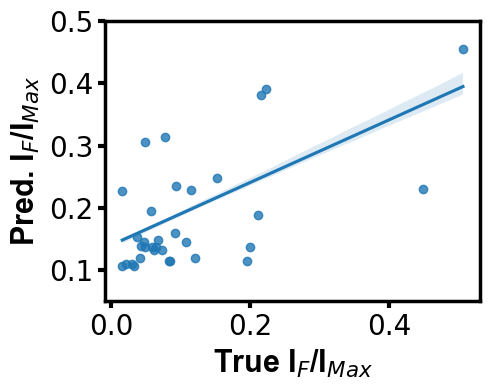

In [14]:
fig, ax = plt.subplots(figsize=(5, 4))
data = pd.DataFrame(())
data['y_pred'] = Final_Current_Percent_test
data['y_true'] = test_labels
data['material'] = df['Material']
# removed outliers
data_outlier_removed = data.loc[data['y_pred'] < 0.6]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
#sns.regplot(data=data_outlier_removed, x='y_test', y='y_pred', ci=70, order=2)
sns.regplot(data=data_outlier_removed, x='y_true', y='y_pred', ci=20, order=1)

ax.set_ylabel('Pred. I$_{F}$/I$_{Max}$', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel('True I$_{F}$/I$_{Max}$', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
#plt.yticks((0.05, 0.3, 0.5))
#plt.xticks((0.1, 0.5, 0.9))
#plt.xlim(-0.1, 1)
plt.ylim(0.05, 0.5)
plt.tight_layout()
plt.savefig('pred_IfinalImax.jpeg', dpi=500)
print (pearsonr(Final_Current_Percent_test, test_labels.ravel())[0])

In [15]:
# Get numerical feature importances
importances = list(xgbr_final_I_percent.feature_importances_)
print (importances)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

[0.06910633, 0.48780632, 0.083638415, 0.12216172, 0.0, 0.043881807, 0.0, 0.040426493, 0.15297891]
Variable: charge_denisty Importance: ('charge_denisty', 0.07)
Variable: PulseTime Importance: ('PulseTime', 0.49)
Variable: material_CB Importance: ('material_CB', 0.08)
Variable: material_MC Importance: ('material_MC', 0.12)
Variable: material_PA Importance: ('material_PA', 0.0)
Variable: material_CB Importance: ('material_CB', 0.04)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.0)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.04)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.15)


In [16]:
# proxy (current-time plot) prediction (Norm_I_Max)
new_features = np.concatenate ((charge_denisty,
                                #np.array (df['Voltage']).reshape(-1, 1),
                                pulsetime,
                                material_type_Norm_I_Max_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=global_rand_state_split
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = rand)

feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

Average of pearson r for test 0.7491001369455906
std of pearson 1 for test 0.007887765205496519 

Average of r_squared for test 0.5553312641336985
std of r_squared for test 0.012296713828729126 

Average of r_squared for train 0.7573563723003816
std of r_squared for train 0.004921710704049213 

r2 score for all =  0.7182507505738802
Mean Absolute Error: 679.6429 units.
r2 score for test =  0.5632704828892025
pearson r for test=  0.7544754225167436


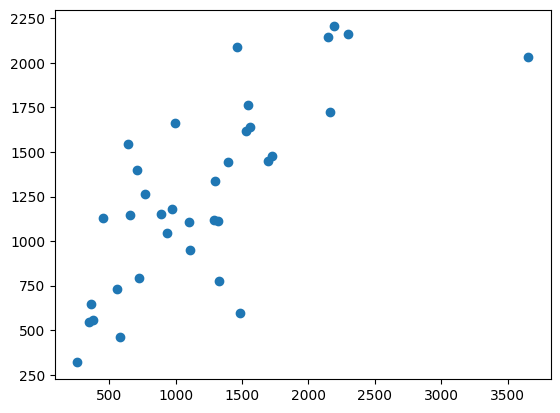

In [17]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):    
    xgbr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=12, 
                  random_state=random_state)
    
    labels = Norm_I_Max
    xgbr_norm_I_max.fit(train_new_features, train_labels);
    
    Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)

    test_labels_ = test_labels.reshape(test_labels.shape[0], )

    Norm_I_Max_test_ = Norm_I_Max_test.reshape(Norm_I_Max_test.shape[0], )

    r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
    r_pearsons.append(r_pearson_Norm_I_Max_test[0])
    r_squareds.append(r_squared_Norm_I_Max_test)
    
    Norm_I_Max_train = xgbr_norm_I_max.predict(train_new_features)
    r_squared_Norm_I_Max_train = r2_score(train_labels, Norm_I_Max_train)
    r_squareds_train.append(r_squared_Norm_I_Max_train)  

xgbr_norm_I_max = XGBRegressor(max_depth=5, n_estimators=35, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=12, 
                  random_state=global_rand_state_xgb)
xgbr_norm_I_max.fit(train_new_features, train_labels);

r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)

plt.scatter(test_labels_, Norm_I_Max_test_)
print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')
print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')
print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)), '\n')

Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_I_Max_predicted - Norm_I_Max)

r_squared_Norm_I_Max_all = r2_score(Norm_I_Max, Norm_I_Max_predicted)
print('r2 score for all = ', r_squared_Norm_I_Max_all)

Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)

errors_test = abs(Norm_I_Max_test - test_labels)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
print('r2 score for test = ', r_squared_Norm_I_Max_test)
pr_Norm_I_Max_test = pearsonr(test_labels.ravel(), Norm_I_Max_test.ravel())
print('pearson r for test= ', pr_Norm_I_Max_test[0])

In [18]:
# proxy (current-time plot) prediction (Norm_Norm_charge_tot)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_Norm_charge_Tot_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=global_rand_state_split
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

In [19]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
# used for hyperparamter tunning.
for random_state in range(4):
    xgbr_norm_charge_total = XGBRegressor(max_depth=3, n_estimators=30, gamma=0.001, 
                   learning_rate=0.118, subsample=0.75, min_child_weight=3, 
                  random_state=global_rand_state_xgb)
    labels = Norm_charge_tot
    xgbr_norm_charge_total.fit(train_new_features, train_labels);
    Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    r_squareds.append(r_squared_Norm_charge_tot_test)
    
    test_labels_ = test_labels.reshape(test_labels.shape[0], )
    Norm_charge_tot_test_ = Norm_charge_tot_test.reshape(Norm_charge_tot_test.shape[0], )
    r_pearson_Norm_charge_tot_test = pearsonr(test_labels_, Norm_charge_tot_test_)
    r_pearsons.append(r_pearson_Norm_charge_tot_test[0])

    Norm_charge_tot_train = xgbr_norm_charge_total.predict(train_new_features)
    r_squared_Norm_charge_tot_train = r2_score(train_labels, Norm_charge_tot_train)
    r_squareds_train.append(r_squared_Norm_charge_tot_train)    

print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)), '\n')

xgbr_norm_charge_total = XGBRegressor(max_depth=4, n_estimators=30, gamma=0.001, 
                   learning_rate=0.0995, subsample=0.75, min_child_weight=3, 
                  random_state=global_rand_state_xgb)
xgbr_norm_charge_total.fit(train_new_features, train_labels)

Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_charge_tot_predicted - Norm_charge_tot)

r_squared_Norm_charge_tot_all = r2_score(Norm_charge_tot, Norm_charge_tot_predicted)
print('r2 score for all = ', r_squared_Norm_charge_tot_all)
pr_Norm_charge_tot_all = pearsonr(Norm_charge_tot.ravel(), Norm_charge_tot_predicted.ravel())
print('pearson r for all = ', pr_Norm_charge_tot_all[0])

# Use the forest's predict method on the test data
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_charge_tot_test - test_labels)
#print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
print('r2 score for test= ', r_squared_Norm_charge_tot_test)
pr_Norm_charge_tot_test = pearsonr(test_labels.ravel(), Norm_charge_tot_test.ravel())
print('pearson r for test= ', pr_Norm_charge_tot_test[0])

Average of pearson r for test 0.7382384755894076
std of pearson 1 for test 0.0 

Average of r_squared for test 0.5274855292612596
std of r_squared for test 0.0 

Average of r_squared for train 0.7870986499521289
std of r_squared for train 0.0 

r2 score for all =  0.7572603184434344
pearson r for all =  0.8877379153279958
r2 score for test=  0.5335168864562696
pearson r for test=  0.7391160029509054


In [20]:
# assume constant resisitivity for precursors
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
heat_power = np.array (df['Voltage']*df['Voltage']/resistance_matrix*df['PulseTime']*(1e-6)).reshape(-1, 1)
# got it from model based prediction of I_Max
# got it from model based prediction of I_Max
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3

material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
# Porxy properties, as well as process parameters
new_features = np.concatenate ((charge_denisty, 
                                X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                material_type_GY_coef,
                                pulsetime,
                                Pretreat_voltage,
                                np.array (df['temp1']).reshape(-1, 1)/1000,
                                #y_pred.reshape(-1, 1),
                                atmosphere_type,
                                Final_Current_Percent_predicted.reshape(-1, 1),
                                Norm_I_Max_predicted.reshape(-1, 1),
                                Norm_charge_tot_predicted.reshape(-1, 1), 
                                heat_power.reshape(-1, 1)
                                ), axis=1)

rand=global_rand_state_split
test_size = 0.2
indices = np.arange(len(new_features))
labels = Graphene_Yield
train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, labels, 
                                       indices, test_size = test_size, random_state = rand
                                       #,stratify=df['Material']
                                      )

feature_list = ['charge_denisty',
                'material_ps',
                'material_res',
                'material_sa',
                'material_sp2',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'PulseTime',
                'Pretreat_voltage',
                'physicsbased_model',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power']

In [21]:
print (test_new_features.shape)
print (test_new_features[0][0])

(35, 18)
68.08510638297872


In [22]:
# stratify added to put same ratio of precursors in test and train
CB_count = sum(df['Material']=='CB')
MC_count = sum(df['Material']=='MC')
PA_count = sum(df['Material']=='PA')
TCB_count = sum(df['Material']=='TCB')
total = CB_count + MC_count + PA_count + TCB_count
print ('CB_count', CB_count, round(CB_count/total, 2),"% of total", total)
print ('MC_count', MC_count, round(MC_count/total, 2),"% of total", total)
print ('PA_count', PA_count, round(PA_count/total, 2),"% of total", total)
print ('TCB_count', TCB_count, round(TCB_count/total, 2),"% of total", total)

print ('CB count for testing {}% is {}'.format(test_size, round(test_size*CB_count, 0)))
print (sum (df['Material'][idx_test]=='CB'))
print ('MC count for testing {}% is {}'.format(test_size, round(test_size*MC_count, 0)))
print (sum (df['Material'][idx_test]=='MC'))
print ('PA count for testing {}% is {}'.format(test_size, round(test_size*PA_count, 0)))
print (sum (df['Material'][idx_test]=='PA'))
print ('TCB count for testing {}% is {}'.format(test_size, round(test_size*TCB_count, 0)))
print (sum (df['Material'][idx_test]=='TCB'))

CB_count 57 0.33 % of total 173
MC_count 44 0.25 % of total 173
PA_count 35 0.2 % of total 173
TCB_count 37 0.21 % of total 173
CB count for testing 0.2% is 11.0
13
MC count for testing 0.2% is 9.0
8
PA count for testing 0.2% is 7.0
7
TCB count for testing 0.2% is 7.0
7


charge_density 0 index 68.08510638297872
RMSE for test,  16.3953
time for 1 of split and 100 rep. is: 2.8115298748016357
r2 mean for test:  [0.56094953]
r2 mean for train:  0.9120614876865671


<AxesSubplot: ylabel='Count'>

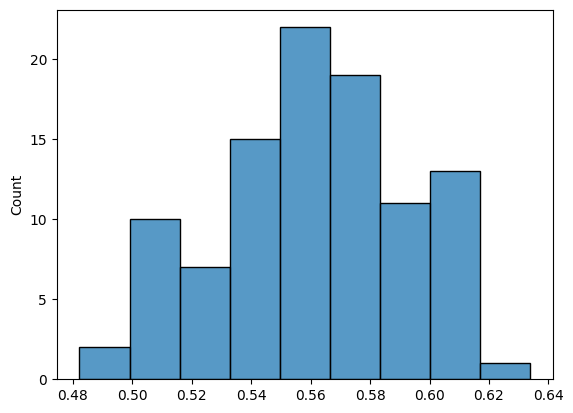

In [38]:
# one random sample from XGBoost: check the last printed r2 is good.
# 362 as random state reaches the best
r_squareds = list()
r_squareds_randomized_testtrain = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
r2_max = 0
test_split_seed1 = global_rand_state_split
test_split_seed2 = global_rand_state_split + 1
test_split_count = test_split_seed2 - test_split_seed1
rep=100
for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       #,stratify=df['Material']
                                       )
    print ('charge_density 0 index', test_new_features[0][0])
    r_squareds = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(rep):
        # Instantiate model with 1000 decision trees
        xgbr_graphyield = XGBRegressor(max_depth=5, n_estimators=40, gamma=0.01, 
                   learning_rate=0.0994, subsample=0.775, min_child_weight=6, 
                   random_state=random_state)
        """
        xgbr_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        xgbr_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = xgbr_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
    
        pred_train = xgbr_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_train)))
    # train accuracy
    pred_train = xgbr_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = xgbr_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    #errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds)
    r_squareds_randomized_testtrain.append (r_squareds)

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())
end = time.time()
print ('time for {} of split and {} rep. is: {}'.format(test_split_count, rep, end-start))
r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
r_squareds_randomized_testtrain_mean = np.mean (r_squareds_randomized_testtrain_vec, axis=1)
print ('r2 mean for test: ', r_squareds_randomized_testtrain_mean)
print ('r2 mean for train: ', np.mean (r_squareds_train))
sns.histplot (r_squareds_randomized_testtrain_vec[0])

#print ('all r2: ', r_squareds_randomized_testtrain_vec)

In [39]:
r_squareds_randomized_testtrain_vec

array([[0.59154405, 0.54547039, 0.51222312, 0.5655404 , 0.60022726,
        0.54339489, 0.54315078, 0.53656652, 0.56495652, 0.55600844,
        0.53101378, 0.53825094, 0.57943716, 0.60603456, 0.53622593,
        0.57228425, 0.61147802, 0.5732815 , 0.53783303, 0.55536863,
        0.56263508, 0.58033033, 0.5639077 , 0.51266785, 0.59632796,
        0.57247554, 0.57310193, 0.55720901, 0.58032343, 0.54462542,
        0.55007987, 0.5898795 , 0.5436755 , 0.57560983, 0.60541905,
        0.50757634, 0.57335681, 0.55521054, 0.56465705, 0.55693344,
        0.60390766, 0.576875  , 0.55672019, 0.60051995, 0.51832299,
        0.58359317, 0.53840743, 0.56142231, 0.63391635, 0.56035842,
        0.58476593, 0.58077018, 0.61048463, 0.57761342, 0.51449843,
        0.56010807, 0.48409686, 0.60095546, 0.562541  , 0.58945876,
        0.50579608, 0.60520269, 0.57594901, 0.50659173, 0.53696707,
        0.55708125, 0.60574437, 0.5114027 , 0.572743  , 0.56901077,
        0.54423393, 0.55954321, 0.59781606, 0.53

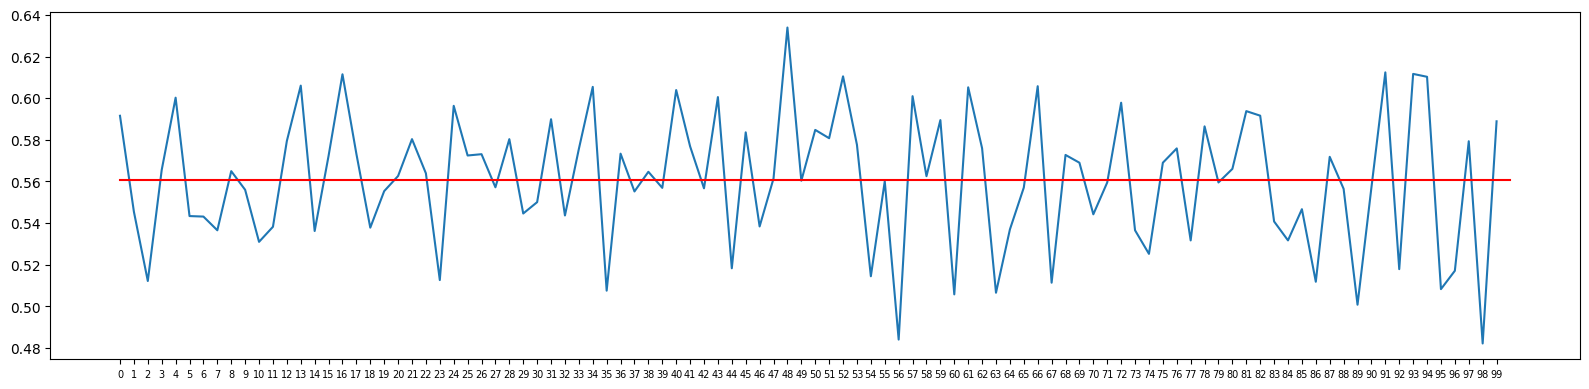

In [40]:
plt.subplots(figsize=(16, 4))
plt.plot (list(range(r_squareds_randomized_testtrain_vec[0].shape[0])), 
             r_squareds_randomized_testtrain_vec[0]);
xticks = list(range(0, r_squareds_randomized_testtrain_vec[0].shape[0], 1));
plt.plot([0, r_squareds_randomized_testtrain_vec[0].shape[0]], 
         [np.mean(r_squareds_randomized_testtrain_vec[0]), 
          np.mean(r_squareds_randomized_testtrain_vec[0])], color='red')
plt.xticks(xticks, fontsize=7);
plt.tight_layout()
plt.savefig('randomrun.jpeg', dpi=500)

In [41]:
pred_test = xgbr_graphyield.predict(test_new_features)
errors_test = (pred_test.reshape(-1, 1) - test_labels)
errors_abs_test = abs(pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['abs_errors'] = errors_abs_test
df_test['Graphene_Yield_per'] = df_test['Graphene_Yield']
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels

# removing outlier
print (r2_score (df_test['y_true'].loc[df_test['errors']<30],
          df_test['y_pred'].loc[df_test['errors']<30]))

0.5879943774562466


In [42]:
df_test.loc[df_test['errors']>20]

,Sample,Material,Atmosphere,Mass,Tube Diam,Pretreat_voltage,Pretreat_highest,Voltage,PulseTime,Res_Volt,...,Norm_charge_tot,Norm_I_Max,charge_density,Final_Current_Percent,errors,Graphene_Yield_per,id_errors,abs_errors,y_pred,y_true
139,141,TCB,vac,299.0,8,140,80,171,196,101.5,...,27.691234,578.781271,65.197324,0.15193,34.975451,7.070707,27,34.975451,42.046158,7.070707


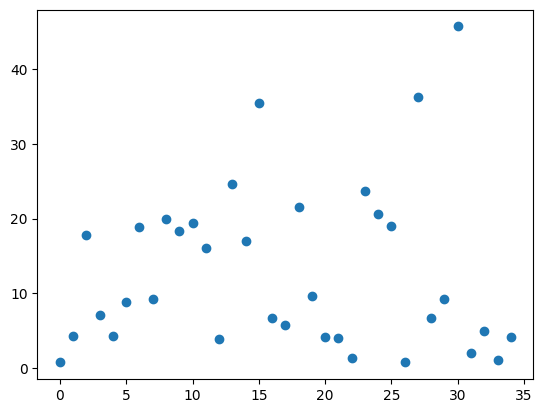

In [28]:
plt.scatter(df_test['id_errors'], df_test['abs_errors'])

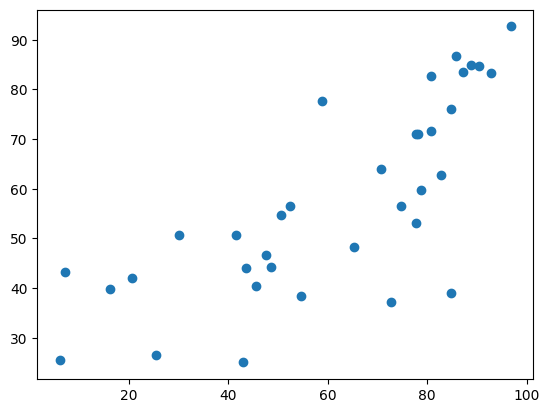

In [29]:
plt.scatter(df_test['y_true'], df_test['y_pred'])

In [30]:
print (df_test['y_true'].loc[df_test['Sample']==90])
print (df_test['y_pred'].loc[df_test['Sample']==90])

Series([], Name: y_true, dtype: float64)
Series([], Name: y_pred, dtype: float32)


In [31]:
r2_score (df_test['y_true'], df_test['y_pred'])

0.5603584157842121

In [32]:
test_labels

array([[47.5609756],
       [50.5050505],
       [42.8571429],
       [78.1512605],
       [48.4848485],
       [84.8484848],
       [58.7301587],
       [41.4141414],
       [82.8282828],
       [74.7474747],
       [ 6.0606061],
       [54.5454545],
       [87.3015873],
       [77.7777778],
       [65.2173913],
       [72.7272727],
       [77.7777778],
       [90.4761905],
       [20.6349206],
       [92.8571429],
       [52.3809524],
       [88.8888889],
       [25.3968254],
       [16.1616162],
       [30.       ],
       [78.7878788],
       [43.4343434],
       [ 7.0707071],
       [70.7070707],
       [80.8080808],
       [84.8484848],
       [80.8510638],
       [45.4545455],
       [85.7142857],
       [96.8253968]])

In [33]:
df_test['y_pred'].loc[df_test['abs_errors']>20]

97     53.140083
93     37.226013
61     42.120480
118    39.853306
60     50.617657
139    43.342209
26     39.111809
Name: y_pred, dtype: float32

/tmp/ipykernel_16252/3350194207.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:
/tmp/ipykernel_16252/3350194207.py:45: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


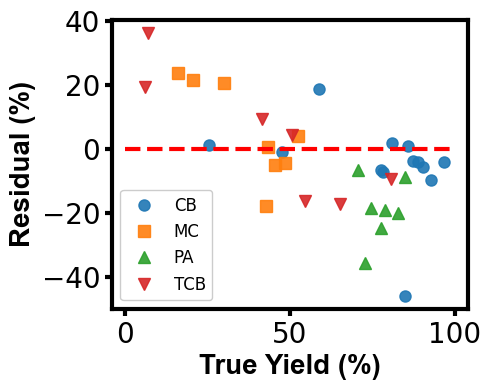

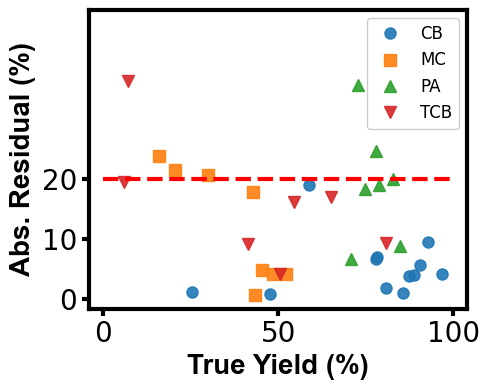

In [34]:
groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12, framealpha=1)
plt.xticks((0, 50, 100))
x = list(range(0, 100))
y = np.repeat(0, 100)
plt.xlim (-4, 104)
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.tight_layout()
plt.savefig('resVSGY_test.jpeg', dpi=500)

pred_test = xgbr_graphyield.predict(test_new_features)
errors_test = abs(pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['Graphene_Yield_per'] = df_test['Graphene_Yield']

groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12, framealpha=1, loc='upper right')
plt.xlim (-4, 104)
x2 = list(range(0, 100))
y2 = np.repeat(20, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Abs. Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
plt.yticks((0, 10, 20))
plt.xticks((0, 50, 100))
plt.tight_layout()
plt.tight_layout()
plt.savefig('abs_resVSGY_test.jpeg', dpi=500)

/tmp/ipykernel_16252/2633315224.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


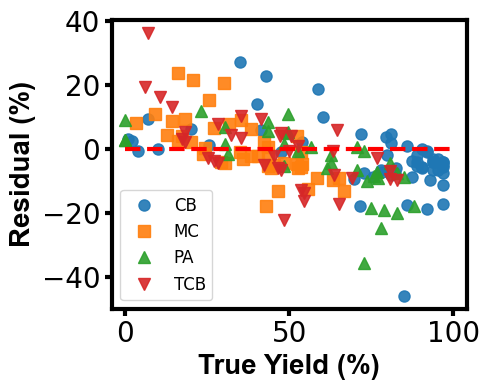

In [35]:
labels = Graphene_Yield
predictions = xgbr_graphyield.predict(new_features)
errors_all = (predictions.reshape(-1, 1) - labels)

df['errors'] = errors_all
df['Graphene_Yield_per'] = df['Graphene_Yield']

groups = df.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')

counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]
plt.xlim (-4, 104)
x = list(range(0, 100))
y = np.repeat(0, 100)
plt.xticks((0, 50, 100))
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
plt.tight_layout()
plt.tight_layout()
plt.savefig('resVSGY.jpeg', dpi=500)

/tmp/ipykernel_16252/4248746353.py:17: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


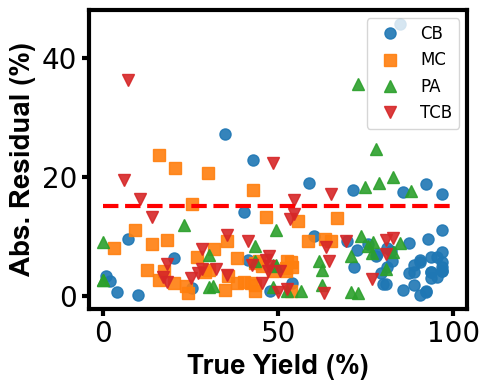

In [36]:
labels = Graphene_Yield
predictions = xgbr_graphyield.predict(new_features)
errors_all = abs(predictions.reshape(-1, 1) - labels)

df['errors'] = errors_all
df['Graphene_Yield_per'] = df['Graphene_Yield']

groups = df.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(fontsize=12)
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_ylabel('Abs. Residual (%)', fontsize='20', fontname='Arial', fontweight='bold')
plt.xlim (-4, 104)

x2 = list(range(0, 100))
y2 = np.repeat(15, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')

plt.tight_layout()
plt.tight_layout()
plt.savefig('abs_resVSGY.jpeg', dpi=500)

/tmp/ipykernel_16252/2633125660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = pred_test
/tmp/ipykernel_16252/2633125660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_true'] = test_labels
/tmp/ipykernel_16252/2633125660.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in gro

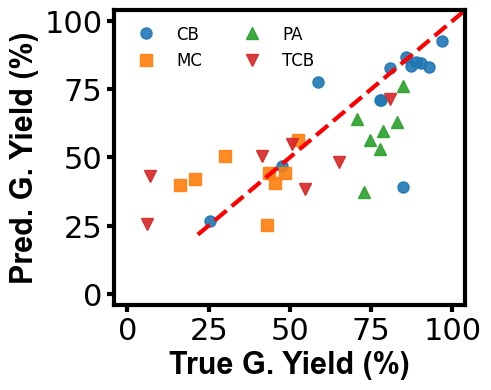

In [37]:
df_test = df.iloc[idx_test]
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels
groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='22')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_true, group.y_pred, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Pred. 2D/G
#plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
ax.set_ylabel('Pred. G. Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
ax.set_xlabel('True G. Yield (%)', fontsize='22', fontname='Arial', fontweight='bold')
[i.set_linewidth(3) for i in ax.spines.values()]
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2, y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')
plt.xlim (-4, 104)
plt.ylim (-4, 104)
plt.xticks((0, 25, 50, 75, 100))
plt.yticks((0, 25, 50, 75, 100))

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_matg.jpeg', dpi=500)
